### Explore the cryptocurrency course over history and see if meanigful predictions ca be made.

In [45]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.style.use('myteststyle.mplstyle')

dataf = 'Bitcoin/Data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv'

timestamp2datetime = lambda T: datetime.utcfromtimestamp(T)
datetime2timestamp = lambda T: T.timestamp()

df = pd.read_csv(dataf, nrows=int(1e8)).dropna()
df.loc[:, 'Datetime'] = df.Timestamp.map(timestamp2datetime)
df.rename(columns={'Weighted_Price':'WPrice'}, inplace=True)
df = df.set_index('Datetime')
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),WPrice
Datetime,,,,,,,,
2011-12-31 07:52:00,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
2011-12-31 15:50:00,1325346600,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000
2011-12-31 16:59:00,1325350740,4.50,4.57,4.50,4.57,37.862297,171.380338,4.526411
2011-12-31 17:00:00,1325350800,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000
2012-01-01 04:16:00,1325391360,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000


### First just plot the rate:

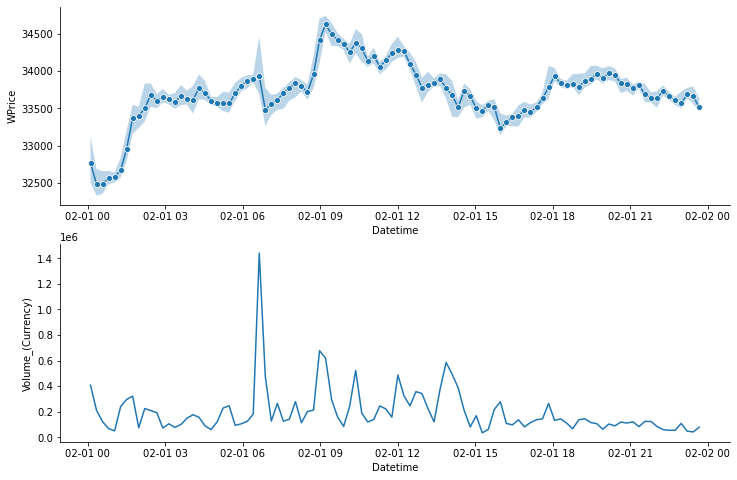

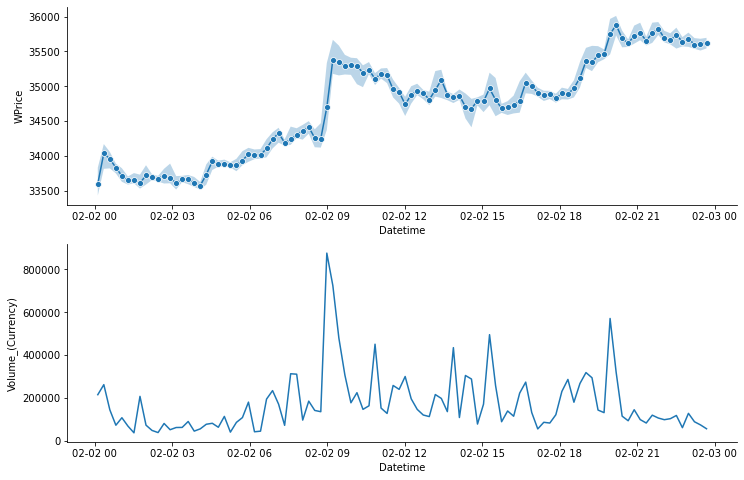

In [126]:
import seaborn as sns

def mask_df_on_date(df, window, end, datetime_col='Datetime'):
    """
    Mask the rate_df so that value between (end - window) and end are returned:
    """
    try:
        return df[end-window:end]
    except KeyError:
        print('WARNING: index did not match with df!')
        mask = (end - window <= df.index) & (df.index < end)
        return df[mask]
    
    
    
def plot_rate(df, start_date, end_date, nwindow=100, preds_df=None, logy=False):
    
    figs = plt.rcParams['figure.figsize'].copy()
    figs[1] *= 2
    _, (ax1, ax2) = plt.subplots(2, figsize=figs)

    
    df_ = mask_df_on_date(df, end_date - start_date, end_date)
    
    nwindow = min(max(1,len(df_)//100), nwindow)
    
    roller = df_.rolling(nwindow)
    rolled = roller.mean() 
    rolled.loc[:, 'High'] = roller.max().loc[:, 'High']
    rolled.loc[:, 'Low'] = roller.min().loc[:, 'Low']
    rolled = rolled.iloc[nwindow-1::nwindow]
    rolled.loc[:, 'Datetime'] = rolled.Timestamp.map(timestamp2datetime)

    for ax, ylab, m in zip((ax1, ax2), ('WPrice', 'Volume_(Currency)'), ('o', '')):
        sns.lineplot(data=rolled, x='Datetime', y=ylab, ax=ax, marker=m)
        if logy: ax.semilogy()

    ax1.fill_between(rolled.Datetime, y1=rolled.Low, y2=rolled.High, alpha=.3)
    
    if preds_df is not None:
        display(preds_df)
        preds_df = mask_df_on_date(preds_df, end_date - start_date, end_date) #, 
                                   #datetime_col = ['pred_at_time', 'pred_for_time'])
        
        for idx in preds_df.index:
            X = [preds_df.loc[idx, 'pred_at_time'], preds_df.loc[idx, 'pred_for_time']]
            Y = [preds_df.loc[idx, 'rate_at_pred'], preds_df.loc[idx, 'rate_pred']]
            ax1.plot(X,Y, '-+', color='black')
        
    plt.show()
    

dt = timedelta(days=1)
start_date = datetime(2021, 2, 1)

for _ in range(2):
    end_date = start_date + dt
    plot_rate(df, start_date, end_date)
    start_date += dt
    


In [127]:
def make_rate_features(T, rate_df):
    """
    Generate features based on past rate at given moment in time.
    
    Attr:
        T : either POSIX time or datime.
        rate_df : Dataframe with rates given w.r.t. time.
    Return:
        features_dict : dictionary of feature value - {'feature_name':value,...}
        avg_price : within a time window used --> this is used to normalize the training data.
    """
    
    window = timedelta(days=1)
    
    if isinstance(T, (int, float)):
        datenow = timestamp2datetime(T)
    elif isinstance(T, datetime):
        datenow = T
    elif isinstance(T, np.datetime64):
        datenow = pd.Timestamp(T)
    else:
        raise ValueError(T)
    
    
    
        
    
    features_d = {}
    
    nhours = 8
    rate_past = mask_df_on_date(rate_df, timedelta(hours=nhours), datenow)
    
    if len(rate_past)==0:
        avg_price=1
        cur_price=-1
    else:
        avg_price = rate_past.WPrice.mean()
        cur_price = rate_past.WPrice.iloc[-1]
        
        
    
    nantozero = lambda val: 0 if np.isnan(val) else val
    
    for h in range(nhours-1):
        hour_price = mask_df_on_date(rate_past, 
                                     np.timedelta64(1, 'h'), 
                                     datenow-np.timedelta64(h, 'h')).WPrice.mean()
        features_d[f'normed_prev_hour_price_(now-{h}h)'] = nantozero(hour_price/avg_price)
    
    nminutes = 60
    deltamins = 5
    for i in range(nminutes//deltamins):
        timepast = deltamins*i
        minute_price = mask_df_on_date(rate_past, 
                                       np.timedelta64(deltamins, 'm'), 
                                       datenow-np.timedelta64(timepast, 'm')).WPrice.mean()
        features_d[f'normed_prev_minute_price_(now-{timepast}m)'] = nantozero(minute_price/avg_price)
    
    
    return features_d, cur_price
    
    


In [128]:
tfuture = np.timedelta64(30, 'm')


get_times = lambda datetimes, tfuture: datetimes - tfuture


### Make the train test split:

In [129]:
split_date = datetime(2021, 1, 1)
rate_test = df[split_date:]
rate_train = df[:split_date]


Then lets generate the training data:

In [ ]:
import sys

train_size = int(3e5)
test_size = 5000
train_sample = rate_train.sample(train_size).sort_values('Timestamp') 


def make_X_y(df, tfuture, size=100):
    rate_col = f'rate_+{tfuture}'

    predict_index = df.sample(size).index
    predict_for_times = df.loc[predict_index].index.values
    predict_at_times = predict_for_times - tfuture
    
    feats, _ = make_rate_features(predict_at_times[0], df)
    nfeats = len(feats)

    X = pd.DataFrame(index=predict_at_times, 
                     data=np.zeros((size, nfeats)), 
                     columns=list(feats.keys()))
    y = pd.DataFrame(index=predict_index, 
                     columns=['rate_prop', 'rate_at_pred', 'rate_true', 'pred_for_time', 'pred_at_time'], 
                     dtype=float)
    i = 0
    start = datetime.now()
    printevery=500
    for idx, predict_at_time, predict_for_time in zip(predict_index, 
                                                      predict_at_times, 
                                                      predict_for_times):
        
            
            
        rate = df.loc[idx, 'WPrice']
        feats, cur_rate = make_rate_features(predict_at_time, df)
        X.loc[predict_at_time, :] = feats
        y.loc[idx, 'rate_prop'] = rate/cur_rate
        y.loc[idx, 'rate_at_pred'] = cur_rate
        y.loc[idx, 'rate_true'] = rate
        y.loc[idx, 'pred_at_time'] = predict_at_time
        y.loc[idx, 'pred_for_time'] = predict_for_time
        i+=1
        
        if i%printevery == 0:
            now = datetime.now()
            fracdone = i/size
            ETA = (now-start)/(fracdone)*(1-fracdone)
            f = '{:.02f} --> ETA: {}'.format(i/size, (now + ETA).strftime('%H:%M:%S'))
            sys.stdout.write("\r" + str(f))
            sys.stdout.flush()
        
    
    return X, y.reindex().loc[:, 'rate_prop'], y

X_train, y_train, y_train_full = make_X_y(rate_train, tfuture, size=train_size)
X_test, y_test, y_test_full = make_X_y(rate_test, tfuture, size=test_size)

0.03 --> ETA: 19:59:37

### Then do the ML...

In [92]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error

weights = 1e6/((split_date - X_train.index).total_seconds() + .1)

#reg = DecisionTreeRegressor(max_depth=10).fit(X_train.values, y_train, sample_weight=weights)
reg = RandomForestRegressor(max_depth=50).fit(X_train.values, y_train, sample_weight=weights)

preds = reg.predict(X_test)

print('Mean squared error: ', mean_squared_error(y_test, preds))

Mean squared error:  8.851044921345864e-05


In [123]:
def make_preds_df(y_test_full, preds):
    preds_df = y_test_full.copy() 
    preds_df.loc[:, 'rate_prop_pred'] = preds
    preds_df.loc[:, 'rate_pred'] = preds_df.loc[:, 'rate_prop_pred']*preds_df.loc[:, 'rate_at_pred']
    
    return preds_df

preds_df = make_preds_df(y_test_full, preds)

Predicted rate change : 1.010
Actual rate change    : 0.999


,rate_prop,rate_at_pred,rate_true,pred_for_time,pred_at_time,rate_prop_pred,rate_pred
Datetime,,,,,,,
2021-01-12 01:09:00,1.012722,34908.819036,35352.926759,2021-01-12T01:09:00.000000000,2021-01-12T00:39:00.000000000,0.987973,34488.953786
2021-03-05 12:26:00,0.995677,47435.657904,47230.597013,2021-03-05T12:26:00.000000000,2021-03-05T11:56:00.000000000,1.000042,47437.670534
2021-03-22 13:22:00,1.001687,57101.477760,57197.782068,2021-03-22T13:22:00.000000000,2021-03-22T12:52:00.000000000,1.002843,57263.800444
2021-01-03 22:13:00,0.987342,33761.116769,33333.763848,2021-01-03T22:13:00.000000000,2021-01-03T21:43:00.000000000,1.001913,33825.695863
2021-02-16 07:18:00,0.997487,49009.429970,48886.287784,2021-02-16T07:18:00.000000000,2021-02-16T06:48:00.000000000,0.997871,48905.105748
...,...,...,...,...,...,...,...
2021-01-08 08:35:00,0.998333,38653.718549,38589.299095,2021-01-08T08:35:00.000000000,2021-01-08T08:05:00.000000000,0.999559,38636.678952
2021-01-05 12:55:00,0.995931,31824.641670,31695.148818,2021-01-05T12:55:00.000000000,2021-01-05T12:25:00.000000000,1.000150,31829.428788
2021-01-19 10:59:00,0.998358,37201.369000,37140.281219,2021-01-19T10:59:00.000000000,2021-01-19T10:29:00.000000000,1.000705,37227.596404


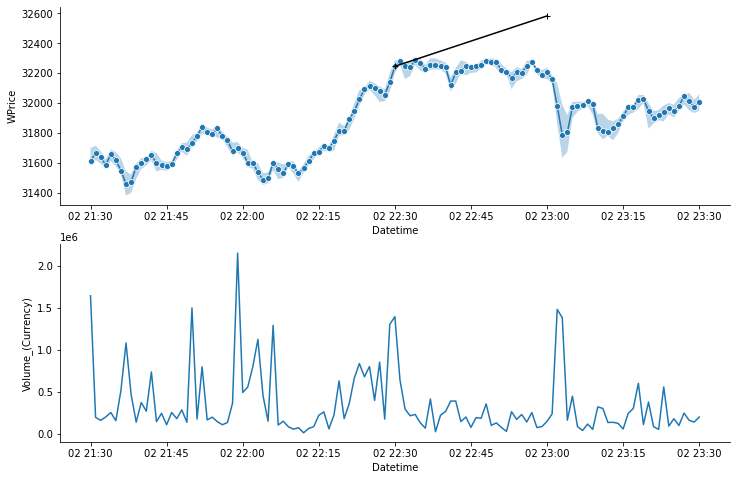

Predicted rate change : 1.013
Actual rate change    : 1.011


,rate_prop,rate_at_pred,rate_true,pred_for_time,pred_at_time,rate_prop_pred,rate_pred
Datetime,,,,,,,
2021-01-12 01:09:00,1.012722,34908.819036,35352.926759,2021-01-12T01:09:00.000000000,2021-01-12T00:39:00.000000000,0.987973,34488.953786
2021-03-05 12:26:00,0.995677,47435.657904,47230.597013,2021-03-05T12:26:00.000000000,2021-03-05T11:56:00.000000000,1.000042,47437.670534
2021-03-22 13:22:00,1.001687,57101.477760,57197.782068,2021-03-22T13:22:00.000000000,2021-03-22T12:52:00.000000000,1.002843,57263.800444
2021-01-03 22:13:00,0.987342,33761.116769,33333.763848,2021-01-03T22:13:00.000000000,2021-01-03T21:43:00.000000000,1.001913,33825.695863
2021-02-16 07:18:00,0.997487,49009.429970,48886.287784,2021-02-16T07:18:00.000000000,2021-02-16T06:48:00.000000000,0.997871,48905.105748
...,...,...,...,...,...,...,...
2021-01-08 08:35:00,0.998333,38653.718549,38589.299095,2021-01-08T08:35:00.000000000,2021-01-08T08:05:00.000000000,0.999559,38636.678952
2021-01-05 12:55:00,0.995931,31824.641670,31695.148818,2021-01-05T12:55:00.000000000,2021-01-05T12:25:00.000000000,1.000150,31829.428788
2021-01-19 10:59:00,0.998358,37201.369000,37140.281219,2021-01-19T10:59:00.000000000,2021-01-19T10:29:00.000000000,1.000705,37227.596404


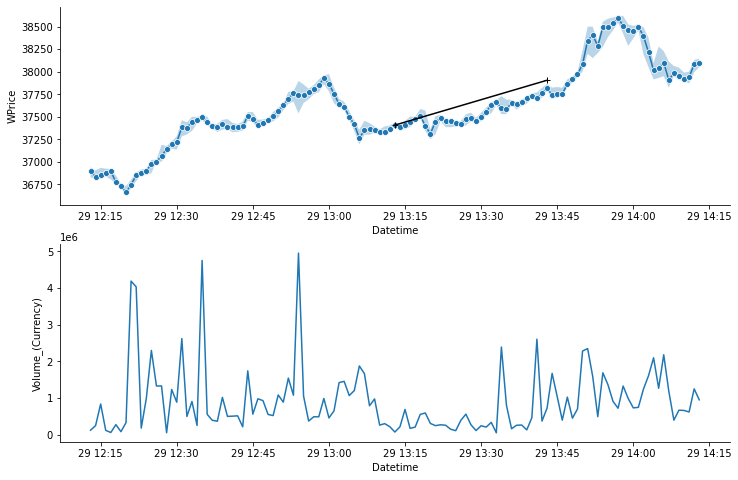

In [125]:
DT = np.timedelta64(1, 'h')
for i in range(len(preds_df)):
    if preds_df.iloc[i].rate_prop_pred <= 1.01: continue
        
    print('Predicted rate change : {:.03f}'.format(preds_df.iloc[i].rate_prop_pred))
    print('Actual rate change    : {:.03f}'.format(preds_df.iloc[i].rate_prop))
    
    
    pred_at = preds_df.iloc[i].pred_at_time
    start_date = max(pred_at - DT, preds_df.index.min()) #timedelta(days=1)
    end_date = pred_at + DT #pred_df.pred_for_time.max() #
    
    
    
    plot_rate(df, start_date, end_date, preds_df=preds_df, logy=False)

In [119]:
preds_df.index.min()

Timestamp('2021-01-01 05:21:00')